This notebook reproduces the experiments from the article "Évaluation des générateurs d’images à partir de peu d’exemples :
calculer le FID avec 10 fois moins d’images, c’est possible" submitted at GRETSI 2025.

First cell is optional, it can be used to setup Python dependencies.

Download the data at: https://ensgeu-my.sharepoint.com/:u:/g/personal/nicolas_audebert_365_ensg_eu/EXEjEC6O12BDmcjGQU-kqowBOP7vLSyuq_Z49sCbc9Ewng?e=YBCZPL

and update `DATAFOLDER` as needed.

In [ ]:
!pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
sns.set_theme() # optional, just for fancy graphs

from scipy import linalg
from tqdm.auto import tqdm

In [2]:
# From https://github.com/GaParmar/clean-fid/blob/main/cleanfid/fid.py
"""
Numpy implementation of the Frechet Distance.
The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
and X_2 ~ N(mu_2, C_2) is
        d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
Stable version by Danica J. Sutherland.
Params:
    mu1   : Numpy array containing the activations of a layer of the
            inception net (like returned by the function 'get_predictions')
            for generated samples.
    mu2   : The sample mean over activations, precalculated on an
            representative data set.
    sigma1: The covariance matrix over activations for generated samples.
    sigma2: The covariance matrix over activations, precalculated on an
            representative data set.
"""
def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)


"""
Compute the FID score given the inception features stack
"""
def fid_from_feats(feats1, feats2):
    mu1, sig1 = np.mean(feats1, axis=0), np.cov(feats1, rowvar=False)
    mu2, sig2 = np.mean(feats2, axis=0), np.cov(feats2, rowvar=False)
    return frechet_distance(mu1, sig1, mu2, sig2)

In [3]:
def rmt_frechet_distance(mu1, sigma1, mu2, sigma2, n1, n2):
    if n1 == n2:
        return rmt_frechet_distance_analytical(mu1, sigma1, mu2, sigma2, n1)
    else:
        raise ValueError(f"n1 should be equal to n2, received n1={n1}, n2={n2}")

def rmt_frechet_distance_analytical(mu1, sigma1, mu2, sigma2, n):
    diff = mu1 - mu2
    eps = 1e-12
    offset = np.eye(sigma1.shape[0]) * eps
    lambda_ = np.sort(np.real(np.linalg.eigvals(sigma1 @ sigma2 + offset)))
    sqrt_lambda = np.sqrt(lambda_).reshape(-1, 1)
    delta = sqrt_lambda @ sqrt_lambda.transpose()
    eta = np.sort(np.real(np.linalg.eigvals(np.diag(lambda_) - (1/n)* delta)))
    covariance_term = np.trace(sigma1 + sigma2) - 2 * (np.sum(sqrt_lambda) - np.sum(np.sqrt(eta)))*(2*n)
    rmt_wasserstein = diff.dot(diff) + covariance_term
    return rmt_wasserstein

def rmt_fid_from_feats(feats1, feats2):
    mu1, sig1 = np.mean(feats1, axis=0), np.cov(feats1, rowvar=False)
    mu2, sig2 = np.mean(feats2, axis=0), np.cov(feats2, rowvar=False)
    return rmt_frechet_distance(mu1, sig1, mu2, sig2, len(feats1), len(feats2))

## Experiments with synthetic data

Let's show that classical estimator converges, but slowly. First on $p=100$ (~low dimension) and then on $p=2048$ (Inception v3 features dimension).

In [4]:
def run_increasing_n_samples_experiment_synthetic(m1, C1, mu2, C2, p=100, n_max=None, n_points=20, verbose=False, random_seed=42, repeats=1):
    if n_max is None:
        n_max = 25 * p
    
    # Shuffle the features (some datasets are ordered by class)
    np.random.seed(random_seed) # fix seed for reproduciblity

    full_x1 = np.random.multivariate_normal(mu1, C1, size=n_max)
    full_x2 = np.random.multivariate_normal(mu2, C2, size=n_max)

    # Reference Wasserstein (true value computed on real covariances)
    true_wasserstein = frechet_distance(mu1, C1, mu2, C2)
    
    all_n_samples = np.linspace(p+1, n_max, num=n_points, dtype=int)
    
    classical_values = np.zeros((len(all_n_samples), repeats))
    classical_values_asym = np.zeros((len(all_n_samples), repeats))
    rmt_values = np.zeros((len(all_n_samples), repeats))
    
    for n_idx, n in enumerate(tqdm(all_n_samples)):
        for run_idx in range(repeats):
            np.random.shuffle(full_x1)
            np.random.shuffle(full_x2)
            x1 = full_x1[:n]
            x2 = full_x2[:n]
        
            classical_wasserstein = fid_from_feats(x1, x2)
            rmt_wasserstein = rmt_fid_from_feats(x1, x2)
            classical_wasserstein_asym = fid_from_feats(full_x1, x2)
        
            classical_values[n_idx, run_idx] = classical_wasserstein
            classical_values_asym[n_idx, run_idx] = classical_wasserstein_asym
            rmt_values[n_idx, run_idx] = rmt_wasserstein

        if verbose:
            print(f"{classical_wasserstein=}")
            print(f"{classical_wasserstein_asym=}")
            print(f"{rmt_wasserstein=}")

    return all_n_samples, classical_values, classical_values_asym, rmt_values, true_wasserstein

In [5]:
p = 100
n_max = 250 * p

# Set random seed for reproducibility
np.random.seed(0)

# Toeplitz covariances, as in (Tiomoko et Couillet, 2019)
mu1 = np.ones(p) * 0.1
mu2 = np.zeros(p)
C1 = linalg.toeplitz([0.2**i for i in range(p)])
C2 = linalg.toeplitz([0.4**i for i in range(p)])

all_n_samples, classical_values, classical_values_asym, rmt_values, true_wasserstein = run_increasing_n_samples_experiment_synthetic(mu1, C1, mu2, C2, n_max=n_max, p=p, repeats=5)

  0%|          | 0/20 [00:00<?, ?it/s]

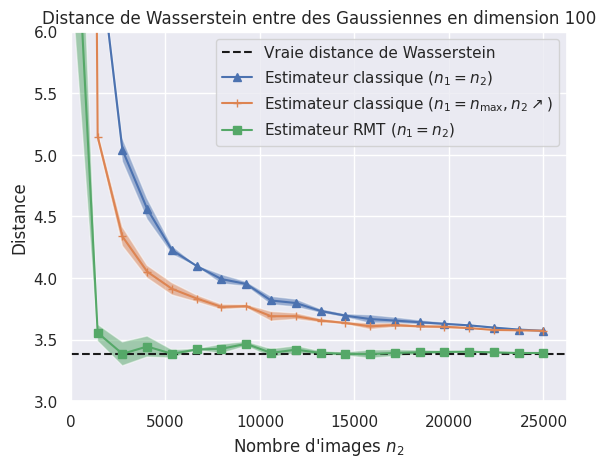

In [6]:
import matplotlib.pyplot as plt

plt.axhline(true_wasserstein, linestyle="--", color="k", label="Vraie distance de Wasserstein")
plt.plot(all_n_samples, np.mean(classical_values, axis=1), marker="^", label="Estimateur classique ($n_1 = n_2$)")
plt.fill_between(all_n_samples, np.mean(classical_values, axis=1) - np.std(classical_values, axis=1), np.mean(classical_values, axis=1) + np.std(classical_values, axis=1), alpha=0.5)
plt.plot(all_n_samples, np.mean(classical_values_asym, axis=1), marker="+", label="Estimateur classique ($n_1 = n_\\text{max}, n_2 \\nearrow$)")
plt.fill_between(all_n_samples, np.mean(classical_values_asym, axis=1) - np.std(classical_values_asym, axis=1), np.mean(classical_values_asym, axis=1) + np.std(classical_values_asym, axis=1), alpha=0.5)
plt.plot(all_n_samples, np.mean(rmt_values, axis=1), marker="s", label="Estimateur RMT ($n_1 = n_2$)")
plt.fill_between(all_n_samples, np.mean(rmt_values, axis=1) - np.std(rmt_values, axis=1), np.mean(rmt_values, axis=1) + np.std(rmt_values, axis=1), alpha=0.5)
plt.ylabel("Distance")
plt.xlabel("Nombre d'images $n_2$")
plt.xlim(0)
plt.ylim(3, 6)
plt.title(f"Distance de Wasserstein entre des Gaussiennes en dimension {p}")
plt.legend()
plt.savefig(f"gaussian_{p=}_fid_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
p = 100
n_max = 2000 * p

# Set random seed for reproducibility
np.random.seed(0)

# Toeplitz covariances, as in (Tiomoko et Couillet, 2019)
# This time the two distributions are identical, so Wasserstein distance should be zero
mu1 = np.ones(p) * 0.1
mu2 = mu1
C1 = linalg.toeplitz([0.2**i for i in range(p)])
C2 = C1

all_n_samples, classical_values, classical_values_asym, rmt_values, true_wasserstein = run_increasing_n_samples_experiment_synthetic(mu1, C1, mu2, C2, n_max=n_max, p=p, repeats=5)

  0%|          | 0/20 [00:00<?, ?it/s]

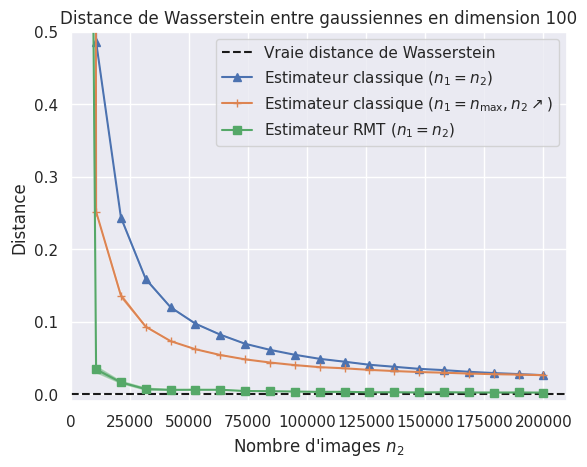

In [8]:
import matplotlib.pyplot as plt

plt.axhline(true_wasserstein, linestyle="--", color="k", label="Vraie distance de Wasserstein")
plt.plot(all_n_samples, np.mean(classical_values, axis=1), marker="^", label="Estimateur classique ($n_1 = n_2$)")
plt.fill_between(all_n_samples, np.mean(classical_values, axis=1) - np.std(classical_values, axis=1), np.mean(classical_values, axis=1) + np.std(classical_values, axis=1), alpha=0.5)
plt.plot(all_n_samples, np.mean(classical_values_asym, axis=1), marker="+", label="Estimateur classique ($n_1 = n_\\text{max}, n_2 \\nearrow$)")
plt.fill_between(all_n_samples, np.mean(classical_values_asym, axis=1) - np.std(classical_values_asym, axis=1), np.mean(classical_values_asym, axis=1) + np.std(classical_values_asym, axis=1), alpha=0.5)
plt.plot(all_n_samples, np.mean(rmt_values, axis=1), marker="s", label="Estimateur RMT ($n_1 = n_2$)")
plt.fill_between(all_n_samples, np.mean(rmt_values, axis=1) - np.std(rmt_values, axis=1), np.mean(rmt_values, axis=1) + np.std(rmt_values, axis=1), alpha=0.5)
plt.ylabel("Distance")
plt.xlabel("Nombre d'images $n_2$")
plt.xlim(0)
plt.ylim(-0.01, 0.5)
plt.title(f"Distance de Wasserstein entre gaussiennes en dimension {p}")
plt.legend()
plt.savefig(f"identical_gaussian_{p=}_fid_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

Same thing now but with $p=2048$.

In [9]:
p = 2048
n_max = 50 * p
all_n_samples = np.linspace(p+1, n_max, num=50, dtype=int)

# Set random seed for reproducibility
np.random.seed(0)

# Toeplitz covariances, as in (Tiomoko et Couillet, 2019)
mu1 = np.ones(p) * 0.1
mu2 = mu1
C1 = linalg.toeplitz([0.2**i for i in range(p)])
C2 = C1

all_n_samples, classical_values, classical_values_asym, rmt_values, true_wasserstein = run_increasing_n_samples_experiment_synthetic(mu1, C1, mu2, C2, n_max=n_max, p=p, repeats=1)

  0%|          | 0/20 [00:00<?, ?it/s]

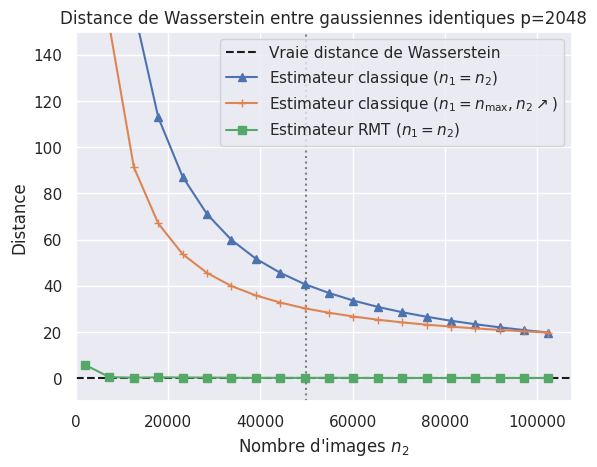

In [10]:
import matplotlib.pyplot as plt

plt.axhline(true_wasserstein, linestyle="--", color="k", label="Vraie distance de Wasserstein")
plt.axvline(50000, linestyle=":", color="gray")
plt.plot(all_n_samples, np.mean(classical_values, axis=1), marker="^", label="Estimateur classique ($n_1 = n_2$)")
plt.fill_between(all_n_samples, np.mean(classical_values, axis=1) - np.std(classical_values, axis=1), np.mean(classical_values, axis=1) + np.std(classical_values, axis=1), alpha=0.5)
plt.plot(all_n_samples, np.mean(classical_values_asym, axis=1), marker="+", label="Estimateur classique ($n_1 = n_\\text{max}, n_2 \\nearrow$)")
plt.fill_between(all_n_samples, np.mean(classical_values_asym, axis=1) - np.std(classical_values_asym, axis=1), np.mean(classical_values_asym, axis=1) + np.std(classical_values_asym, axis=1), alpha=0.5)
plt.plot(all_n_samples, np.mean(rmt_values, axis=1), marker="s", label="Estimateur RMT ($n_1 = n_2$)")
plt.fill_between(all_n_samples, np.mean(rmt_values, axis=1) - np.std(rmt_values, axis=1), np.mean(rmt_values, axis=1) + np.std(rmt_values, axis=1), alpha=0.5)
plt.ylabel("Distance")
plt.xlabel("Nombre d'images $n_2$")
plt.xlim(0)
plt.ylim(-10, 150)
plt.title(f"Distance de Wasserstein entre gaussiennes identiques {p=}")
plt.legend()
plt.savefig(f"identical_gaussian_{p=}_fid_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Experiments with CIFAR-10

In [11]:
DATAFOLDER = "./data/"

Reference implementation:

In [12]:
import cleanfid.fid
score = cleanfid.fid.compute_fid(os.path.join(DATAFOLDER, "saved_images_cifar10_stylegan2/"),
                                 dataset_name="cifar10", mode="legacy_pytorch",
                                 batch_size=50, dataset_res=32)
print(f"Clean FID {score}")

/home/nicolas/.venvs/dl/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nicolas/.venvs/dl/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


compute FID of a folder with cifar10 statistics
Found 50000 images in the folder ./data/saved_images_cifar10_stylegan2/


FID  : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:20<00:00,  3.83it/s]


Clean FID 2.4943166201750273


In [13]:
# Import helpers from cleanfid to extract features from a folder
from cleanfid.fid import get_folder_features, build_feature_extractor

import torch
import os

def compute_features_from_dir(fdir, mode="clean", model_name="inception_v3", num_workers=12,
                              batch_size=32, device=torch.device("cuda"), verbose=True,
                              custom_feat_extractor=None, custom_image_tranform=None,
                              custom_fn_resize=None, use_dataparallel=True):
    
    # build the feature extractor based on the mode and the model to be used
    if custom_feat_extractor is None and model_name=="inception_v3":
        feat_model = build_feature_extractor(mode, device, use_dataparallel=use_dataparallel)
    elif custom_feat_extractor is None and model_name=="clip_vit_b_32":
        from cleanfid.clip_features import CLIP_fx, img_preprocess_clip
        clip_fx = CLIP_fx("ViT-B/32", device=device)
        feat_model = clip_fx
        custom_fn_resize = img_preprocess_clip
    else:
        feat_model = custom_feat_extractor

    # Extract Inception features from the folder
    fbname = os.path.basename(fdir)
    np_feats = get_folder_features(fdir, feat_model, num_workers=num_workers,
                                   batch_size=batch_size, device=device, mode=mode,
                                   description=f"Extracting features from {fbname} : ", verbose=verbose,
                                   custom_image_tranform=custom_image_tranform,
                                   custom_fn_resize=custom_fn_resize)

    return np_feats

Experiments for CIFAR-10

In [14]:
cifar10_train_features = compute_features_from_dir(os.path.join(DATAFOLDER, "cifar10/images/"), batch_size=50)
cifar10_stylegan_features = compute_features_from_dir(os.path.join(DATAFOLDER, "saved_images_cifar10_stylegan2/"), batch_size=50)

Found 50000 images in the folder ./data/cifar10/images/


Extracting features from  : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:59<00:00,  4.18it/s]


Found 50000 images in the folder ./data/saved_images_cifar10_stylegan2/


Extracting features from  : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:59<00:00,  4.17it/s]


In [15]:
fid_from_feats(cifar10_train_features, cifar10_stylegan_features)

np.float64(3.1473259159536155)

In [16]:
def run_increasing_n_samples_experiment(true_features, fake_features, n_points=10, verbose=False, random_seed=42, repeats=1):
    n_max = min(len(true_features), len(fake_features))
    # Shuffle the features (some datasets are ordered by class)
    np.random.seed(random_seed) # fix seed for reproduciblity
    p = true_features.shape[-1]
    
    all_n_samples = np.linspace(p+1, n_max, num=n_points, dtype=int)
    
    classical_values = np.zeros((len(all_n_samples), repeats))
    classical_values_asym = np.zeros((len(all_n_samples), repeats))
    rmt_values = np.zeros((len(all_n_samples), repeats))
    
    for n_idx, n in enumerate(tqdm(all_n_samples)):
        for run_idx in range(repeats):
            np.random.shuffle(true_features)
            np.random.shuffle(fake_features)
            x1 = true_features[:n]
            x2 = fake_features[:n]
        
            classical_wasserstein = fid_from_feats(x1, x2)
            rmt_wasserstein = rmt_fid_from_feats(x1, x2)
            classical_wasserstein_asym = fid_from_feats(true_features, x2)
        
            classical_values[n_idx, run_idx] = classical_wasserstein
            classical_values_asym[n_idx, run_idx] = classical_wasserstein_asym
            rmt_values[n_idx, run_idx] = rmt_wasserstein

        if verbose:
            print(f"{classical_wasserstein=}")
            print(f"{classical_wasserstein_asym=}")
            print(f"{rmt_wasserstein=}")

    return all_n_samples, classical_values, classical_values_asym, rmt_values

Run FID estimations with variable number of samples:

In [17]:
all_n_samples, classical_values, classical_values_asym, rmt_values = run_increasing_n_samples_experiment(cifar10_train_features, cifar10_stylegan_features, n_points=20, repeats=1)

  0%|          | 0/20 [00:00<?, ?it/s]

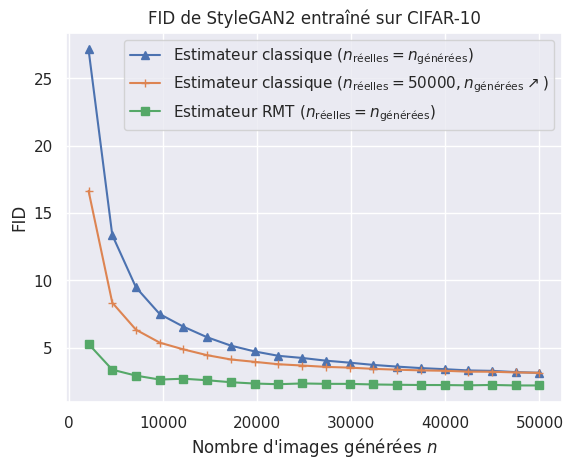

In [18]:
import matplotlib.pyplot as plt


plt.plot(all_n_samples, np.mean(classical_values, axis=1), marker="^", label="Estimateur classique ($n_\\text{réelles} = n_\\text{générées}$)")
#plt.fill_between(all_n_samples, np.mean(classical_values, axis=1) - np.std(classical_values, axis=1), np.mean(classical_values, axis=1) + np.std(classical_values, axis=1))
plt.plot(all_n_samples, np.mean(classical_values_asym, axis=1), marker="+", label=f"Estimateur classique ($n_\\text{{réelles}} = {len(cifar10_train_features)}, n_\\text{{générées}} \\nearrow$)")
#plt.fill_between(all_n_samples, np.mean(classical_values_asym, axis=1) - np.std(classical_values_asym, axis=1), np.mean(classical_values_asym, axis=1) + np.std(classical_values_asym, axis=1))
plt.plot(all_n_samples, np.mean(rmt_values, axis=1), marker="s", label="Estimateur RMT ($n_\\text{réelles} = n_\\text{générées}$)")
#plt.fill_between(all_n_samples, np.mean(rmt_values, axis=1) - np.std(rmt_values, axis=1), np.mean(rmt_values, axis=1) + np.std(rmt_values, axis=1))
plt.ylabel("FID")
plt.xlabel("Nombre d'images générées $n$")
plt.title(f"FID de StyleGAN2 entraîné sur CIFAR-10")
plt.legend()
plt.savefig("stylegan2_cifar10_fid_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Experiments with AFHQ-Cats

Reference implementation:

In [21]:
import cleanfid.fid
score = cleanfid.fid.compute_fid(os.path.join(DATAFOLDER, "saved_images_afhqcats_stylegan2/"),
                                 dataset_name="afhq_cat", mode="legacy_pytorch",
                                 batch_size=50, dataset_res=512)
print(f"Clean FID {score}")

compute FID of a folder with afhq_cat statistics
Found 5153 images in the folder ./data/saved_images_afhqcats_stylegan2/


FID  : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:27<00:00,  3.74it/s]


Clean FID 4.463942652077975


In [22]:
afhqcats_train_features = compute_features_from_dir(os.path.join(DATAFOLDER, "afhq/train/cat/"), batch_size=50, mode="legacy_pytorch")
afhqcats_stylegan_features = compute_features_from_dir(os.path.join(DATAFOLDER, "saved_images_afhqcats_stylegan2/"), batch_size=50, mode="legacy_pytorch")
fid_from_feats(afhqcats_train_features, afhqcats_stylegan_features)

Found 5153 images in the folder ./data/afhq/train/cat/


Extracting features from  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:27<00:00,  3.80it/s]


Found 5153 images in the folder ./data/saved_images_afhqcats_stylegan2/


Extracting features from  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:28<00:00,  3.66it/s]


np.float64(4.242536874855347)

Run FID estimations with variable number of samples:

In [23]:
all_n_samples, classical_values, classical_values_asym, rmt_values = run_increasing_n_samples_experiment(afhqcats_train_features, afhqcats_stylegan_features[:len(afhqcats_train_features)], n_points=20)

  0%|          | 0/20 [00:00<?, ?it/s]

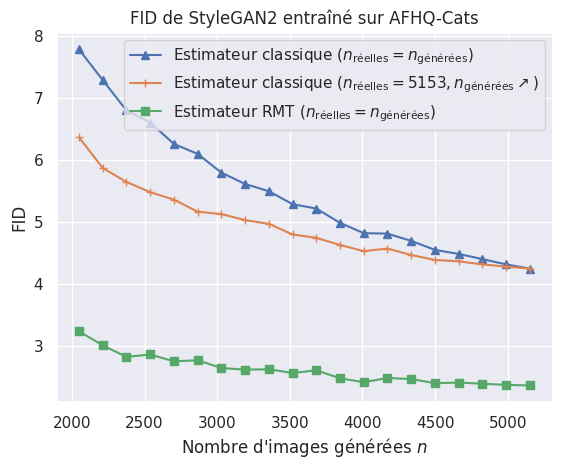

In [24]:
import matplotlib.pyplot as plt


plt.plot(all_n_samples, np.mean(classical_values, axis=1), marker="^", label="Estimateur classique ($n_\\text{réelles} = n_\\text{générées}$)")
#plt.fill_between(all_n_samples, np.mean(classical_values, axis=1) - np.std(classical_values, axis=1), np.mean(classical_values, axis=1) + np.std(classical_values, axis=1))
plt.plot(all_n_samples, np.mean(classical_values_asym, axis=1), marker="+", label=f"Estimateur classique ($n_\\text{{réelles}} = {len(afhqcats_train_features)}, n_\\text{{générées}} \\nearrow$)")
#plt.fill_between(all_n_samples, np.mean(classical_values_asym, axis=1) - np.std(classical_values_asym, axis=1), np.mean(classical_values_asym, axis=1) + np.std(classical_values_asym, axis=1))
plt.plot(all_n_samples, np.mean(rmt_values, axis=1), marker="s", label="Estimateur RMT ($n_\\text{réelles} = n_\\text{générées}$)")
#plt.fill_between(all_n_samples, np.mean(rmt_values, axis=1) - np.std(rmt_values, axis=1), np.mean(rmt_values, axis=1) + np.std(rmt_values, axis=1))
plt.ylabel("FID")
plt.xlabel("Nombre d'images générées $n$")
#plt.xlim(0)
plt.title(f"FID de StyleGAN2 entraîné sur AFHQ-Cats")
plt.legend()
plt.savefig("stylegan2_afhqcats_fid_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()


Code below details how the original data was collected and/or generated. StyleGAN2 assumes access to the StyleGAN2-ADA codebase, i.e.:
```bash
git clone https://github.com/NVlabs/stylegan2-ada-pytorch/
```

# StyleGAN2-ADA AFHQ-Cats

```
python generate.py --network afhqcat.pkl --seeds 1-5153 --outdir saved_images_afhqcats_stylegan2/
```


# StyleGAN2-ADA CIFAR-10
```
python generate.py --network cifar10.pkl --class 0 --seeds 1-5000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 1 --seeds 5001-10000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 2 --seeds 10001-15000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 3 --seeds 15001-20000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 4 --seeds 20001-25000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 5 --seeds 25001-30000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 6 --seeds 30001-35000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 7 --seeds 35001-40000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 8 --seeds 40001-45000 --outdir saved_images_cifar10_stylegan2/
python generate.py --network cifar10.pkl --class 9 --seeds 45001-50000 --outdir saved_images_cifar10_stylegan2/
```

# CIFAR-10
```python
import os

from torchvision import datasets
dataset = CIFAR10("./cifar10/", train=True, download=True)

os.makedirs("./cifar10/images/train/", exists_ok=True)
for idx, (image, _) in enumerate(tqdm(cifar)):
    image.save(f"./cifar10/images/train/{idx:05d}.png")
```

# AFHQ-Cats
```bash
wget -N "https://www.dropbox.com/s/t9l9o3vsx2jai3z/afhq.zip?dl=0" -O afhq.zip
unzip afhq.zip
```

In [25]:
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns

from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage import io

sns.set_style("whitegrid", {'axes.grid' : False})

DATAFOLDER = "./data/"

def sample_n_images_in_folder(files, n=4, seed=42):
    random.seed(a=seed)
    files = random.choices(files, k=n)
    images = np.array([io.imread(image) for image in files])
    
    fig = plt.figure(figsize=(16., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, n),  # creates 2x2 grid of Axes
                     axes_pad=0.1,  # pad between Axes in inch.
                     )
    
    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_axis_off()

    plt.show()
    return fig

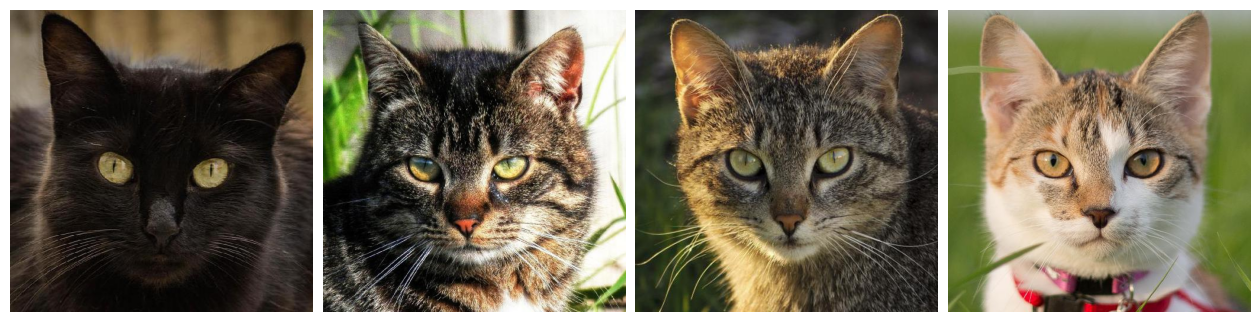

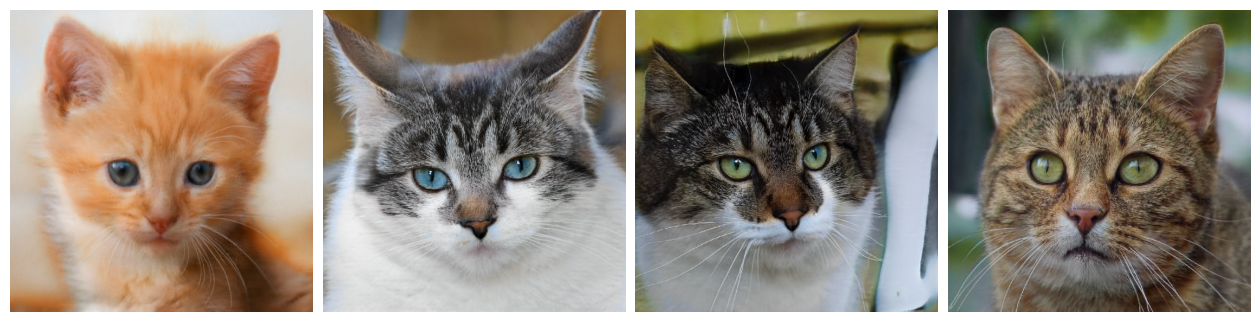

In [26]:
fig = sample_n_images_in_folder(glob(os.path.join(DATAFOLDER, "afhq/train/cat/*.jpg")))
fig.savefig("afhqcats_real_samples.jpg", format="jpg", bbox_inches="tight")
fig = sample_n_images_in_folder(glob(os.path.join(DATAFOLDER, "saved_images_afhqcats_stylegan2/*.png")))
fig.savefig("afhqcats_stylegan2_samples.jpg", format="jpg", bbox_inches="tight")

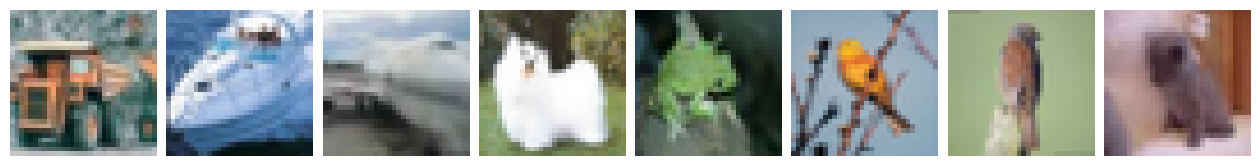

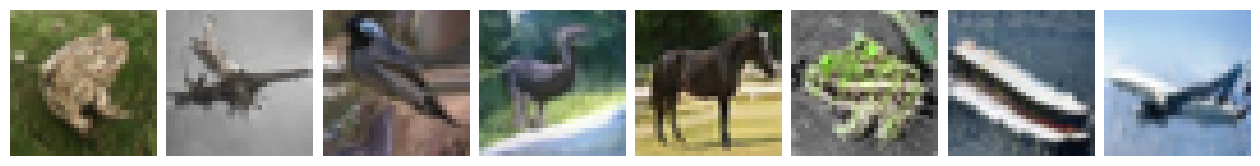

In [27]:
fig = sample_n_images_in_folder(glob(os.path.join(DATAFOLDER, "cifar10/images/train/*.png")), n=8)
fig.savefig("cifar10_real_samples.jpg", format="jpg", bbox_inches="tight")
fig = sample_n_images_in_folder(glob(os.path.join(DATAFOLDER, "saved_images_cifar10_stylegan2/*.png")), n=8)
fig.savefig("cifar10_stylegan2_samples.jpg", format="jpg", bbox_inches="tight")